In [1]:
import numpy as np
import cvxpy as cp
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.special import gamma
import itertools
import time
import mosek
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
import pandas as pd

In [60]:
def plot_eval(df, quantiles, df1=None, quantiles1=None, dro = False,end_ind=61,j=(0,0,0), q = (40,60),K=5, alpha=0.1):
    j1,j2,j3 = j
    # Set up LaTeX rendering
    df = df[K]
    fontsize= 10
    quantiles = quantiles[K]
    q1,q2 = q
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "font.size": fontsize,
        "axes.labelsize": fontsize,
        "axes.titlesize": fontsize,
        "legend.fontsize": fontsize
    })
    t_range = np.array(df['t'])[(0*end_ind)+1:(1)*end_ind:2]
    plt.figure(figsize=(6, 3), dpi=300)
    plt.plot(t_range, df['O_eval0'][(j1*end_ind)+1:(j1+1)*end_ind:2], 'b-', linewidth=2, label = "online clustering")

    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['O_eval0'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['O_eval0'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),alpha=alpha, color = 'b')
    plt.plot(t_range, df['MRO_eval0'][(j2*end_ind)+1:(j2+1)*end_ind:2], 'r-', linewidth=2, label = "reclustering")
    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['MRO_eval0'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['MRO_eval0'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),alpha=alpha, color='r')

    if dro:
        plt.plot(t_range, df1['SA_eval1'][(j3*end_ind):(j3+1)*end_ind-1:2], 'g-', linewidth=2, label = "SAA")
        # plt.plot(t_range, df1['DRO_eval0'][(j3*end_ind):(j3+1)*end_ind-1:2], color ='black', linewidth=2, label = "DRO")
        plt.fill_between(np.array(t_range),y1=np.array(quantiles1[q1]['SA_eval1'][(j3*end_ind)+1:(j3+1)*end_ind:2]).astype(float),y2=np.array(quantiles1[q2]['SA_eval1'][(j3*end_ind)+1:(j3+1)*end_ind:2]).astype(float),alpha=alpha, color='g')
        # plt.fill_between(np.array(t_range),y1=np.array(quantiles1[q1]['DRO_eval0'][(j3*end_ind)+1:(j3+1)*end_ind:2]).astype(float),y2=np.array(quantiles1[q2]['DRO_eval0'][(j3*end_ind)+1:(j3+1)*end_ind:2]).astype(float),alpha=alpha, color='black')

    plt.ylim([0.008,0.022])
    plt.legend()
    plt.xlabel(r'Time step $(t)$')
    plt.ylabel(r'Evaluation value (out of sample)')
    plt.grid(True, alpha=alpha)
    plt.savefig('eval_analysis.pdf', bbox_inches='tight', dpi=300)

    plt.figure(figsize=(7, 4), dpi=300)
    plt.plot(t_range, df['obj_values'][(j1*end_ind):(j1+1)*end_ind-1:2], 'b-', linewidth=2, label = "online clustering")
    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['obj_values'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['obj_values'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),alpha=alpha, color = 'b')
    plt.plot(t_range, df['MRO_obj_values'][(j2*end_ind):(j2+1)*end_ind-1:2], 'r-', linewidth=2, label = "reclustering")
    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['MRO_obj_values'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['MRO_obj_values'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),alpha=alpha, color='r')
    # plt.plot(t_range, df['worst_values'][(j2*end_ind):(j2+1)*end_ind-1:2], 'b-.', linewidth=2, label = r"online clustering $\hat{H}^K_t$")
    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['MRO_worst_values'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['MRO_worst_values'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),alpha=alpha, color='r')
    plt.plot(t_range, df['MRO_worst_values'][(j2*end_ind):(j2+1)*end_ind-1:2], 'r-.', linewidth=2, label = r"reclustering $\hat{H}^K_t$")
    # plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['worst_values'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['worst_values'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),alpha=alpha, color = 'b')
    if dro:
        plt.plot(t_range, df1['SA_obj_values'][(j3*end_ind):(j3+1)*end_ind-1:2], 'g-', linewidth=2, label = "SAA")
        # plt.plot(t_range, df1['DRO_obj_values'][(j3*end_ind):(j3+1)*end_ind-1:2], color ='black', linewidth=2, label = "DRO")
        # plt.fill_between(np.array(t_range),y1=np.array(quantiles1[q1]['DRO_obj_values'][(j3*end_ind)+1:(j3+1)*end_ind:2]).astype(float),y2=np.array(quantiles1[q2]['DRO_obj_values'][(j3*end_ind)+1:(j3+1)*end_ind:2]).astype(float),alpha=alpha, color = 'black')
        plt.fill_between(np.array(t_range),y1=np.array(quantiles1[q1]['SA_obj_values'][(j3*end_ind)+1:(j3+1)*end_ind:2]).astype(float),y2=np.array(quantiles1[q2]['SA_obj_values'][(j3*end_ind)+1:(j3+1)*end_ind:2]).astype(float),alpha=alpha, color = 'g')

    plt.legend()
    plt.xlabel(r'Time step $(t)$')
    plt.ylabel(r'Objective value (in sample)')
    plt.ylim([0.008,0.022])
    plt.grid(True, alpha=alpha)
    plt.savefig('obj_analysis.pdf', bbox_inches='tight', dpi=300)

    # plt.figure(figsize=(7, 4), dpi=300)
    # plt.plot(t_range, df['obj_values'][(j*end_ind):(j+1)*end_ind-1:2], 'b-', linewidth=2, label = "online clustering")
    # plt.plot(t_range, df['MRO_obj_values'][(j*end_ind):(j+1)*end_ind-1:2], 'r-', linewidth=2, label = "reclustering")
    # if dro:
    #     plt.plot(t_range, df1['DRO_obj_values'][(j*end_ind):(j+1)*end_ind-1:2], color ='black', linewidth=2, label = "DRO")
    #     plt.plot(t_range, df1['SA_obj_values'][(j*end_ind):(j+1)*end_ind-1:2], 'g-', linewidth=2, label = "SAA")
    #     plt.plot(t_range, df1['DRO_eval0'][(j*end_ind)+1:(j+1)*end_ind:2], color ='black', linestyle='-.')
    #     plt.plot(t_range, df1['SA_eval1'][(j*end_ind)+1:(j+1)*end_ind:2],'g', linestyle='-.')
    # plt.plot(t_range, df['O_eval0'][(j*end_ind)+1:(j+1)*end_ind:2],  'b', linewidth=2, linestyle='-.')
    # plt.plot(t_range, df['MRO_eval0'][(j*end_ind)+1:(j+1)*end_ind:2], 'r', linewidth=2, linestyle='-.')
   
    # plt.legend()
    # plt.xlabel(r'Time step $(t)$')
    # plt.ylabel(r'Objective value and evaluation value')
    # plt.grid(True, alpha=alpha)
    # plt.savefig('obj_eval_analysis.pdf', bbox_inches='tight', dpi=300)

In [61]:
def plot_computation_times(df):
    """Plot computation time analysis with LaTeX formatting."""
    # Set up LaTeX rendering
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "font.size": 22,
        "axes.labelsize": 22,
        "axes.titlesize": 22,
        "legend.fontsize": 22
    })
    
    # Create figure
    plt.figure(figsize=(15, 3), dpi=300)
    
    # Prepare data for boxplot
    data = [
        df['online_time'][::25], df['MRO_time'][::25],df['DRO_time'][::25]
    ]
    # Create boxplot
    bp = plt.boxplot(data, labels=[

        r'online clustering', r'reclustering', r'DRO' 
    ])
    
    # Customize boxplot colors
    plt.setp(bp['boxes'], color='blue')
    plt.setp(bp['whiskers'], color='blue')
    plt.setp(bp['caps'], color='blue')
    plt.setp(bp['medians'], color='red')

    
    # Add grid and labels
    plt.grid(True, alpha=alpha)
    plt.ylabel(r'Compuation time')
    plt.yscale("log")
    # plt.savefig('time.pdf', bbox_inches='tight', dpi=300)

def plot_computation_times_iter(df, quantiles, df1=None, quantiles1=None, dro = False,end_ind=61,j=(0,0,0), q = (40,60),K=5, alpha=0.1):
    j1,j2,j3 = j
    df = df[K]
    fontsize= 10
    quantiles = quantiles[K]
    q1,q2 = q
    # Set up LaTeX rendering
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "font.size": fontsize
    })
    t_range = np.array(df['t'])[(0*end_ind)+1:(1)*end_ind:2]
    plt.figure(figsize=(6, 3), dpi=300)
    plt.plot(t_range, df['online_time'][(j1*end_ind)+1:(j1+1)*end_ind:2], 'b-', linewidth=2, label = "online clustering")
    plt.plot(t_range, df['MRO_time'][(j2*end_ind)+1:(j2+1)*end_ind:2], 'r-', linewidth=2, label = "reclustering")
    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['online_time'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['online_time'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),alpha=alpha, color = 'b')
    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['MRO_time'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['MRO_time'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),alpha=alpha, color = 'r')

    # plt.plot(t_range, df['worst_times'][(j1*end_ind)+1:(j1+1)*end_ind:2], 'b-.', linewidth=2, label = r"online clustering $\hat{H}^K_t$")
    plt.plot(t_range, df['MRO_worst_times'][(j1*end_ind)+1:(j1+1)*end_ind:2], 'r-.', linewidth=2, label = r"reclustering $\hat{H}^K_t$")
    # plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['worst_times'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['worst_times'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),alpha=alpha, color = 'b')
    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['MRO_worst_times'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['MRO_worst_times'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),alpha=alpha, color = 'r')

    if dro:
        # plt.plot(t_range, df1['DRO_time'][(j3*end_ind)+1:(j3+1)*end_ind:2], color ='black', linewidth=2, label = "DRO")
        plt.plot(t_range, df1['SA_time'][(j3*end_ind)+1:(j3+1)*end_ind:2], color ='g', linewidth=2, label = "SAA")
        # plt.fill_between(np.array(t_range),y1=np.array(quantiles1[q1]['DRO_time'][(j3*end_ind)+1:(j3+1)*end_ind:2]).astype(float),y2=np.array(quantiles1[q2]['DRO_time'][(j3*end_ind)+1:(j3+1)*end_ind:2]).astype(float),alpha=alpha, color = 'black')
        plt.fill_between(np.array(t_range),y1=np.array(quantiles1[q1]['SA_time'][(j3*end_ind)+1:(j3+1)*end_ind:2]).astype(float),y2=np.array(quantiles1[q2]['SA_time'][(j3*end_ind)+1:(j3+1)*end_ind:2]).astype(float),alpha=alpha, color = 'g')

    plt.legend()
    plt.xlabel(r'Time step $(t)$')
    plt.ylabel(r'Compuation time per iteration (s)')
    plt.grid(True, alpha=0.3)
    plt.yscale("log")
    plt.savefig('time_iters.pdf', bbox_inches='tight', dpi=300)

In [62]:
def plot_computation_times_cum(df, quantiles, df1=None, quantiles1=None, dro = False,end_ind=61,j=(0,0,0), q = (40,60),K=5, alpha=0.1):
    df = df[K]
    fontsize= 10
    j1,j2,j3 = j
    quantiles = quantiles[K]
    q1,q2 = q
    mult=100
    # Set up LaTeX rendering
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "font.size": fontsize
    })
    t_range = np.array(df['t'])[(0*end_ind)+1:(1)*end_ind:2]
    plt.figure(figsize=(6, 3), dpi=300)
    plt.plot(t_range, mult*np.cumsum(df['online_time'][(j1*end_ind)+1:(j1+1)*end_ind:2]), 'b-', linewidth=2, label = "online clustering")
    plt.plot(t_range, mult*np.cumsum(df['MRO_time'][(j2*end_ind)+1:(j2+1)*end_ind:2]), 'r-', linewidth=2, label = "reclustering")
    plt.fill_between(np.array(t_range),y1=mult*np.cumsum(np.array(quantiles[q1]['online_time'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float)),y2=mult*np.cumsum(np.array(quantiles[q2]['online_time'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float)),alpha=alpha, color = 'b')
    plt.fill_between(np.array(t_range),y1=mult*np.cumsum((np.array(quantiles[q1]['MRO_time'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float))),y2=mult*np.cumsum(np.array(quantiles[q2]['MRO_time'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float)),alpha=alpha, color = 'r')

    # plt.plot(t_range, np.cumsum(df['worst_times'][(j*end_ind)+1:(j+1)*end_ind:2]), 'b-.', linewidth=2, label = "online clustering worst")
    plt.plot(t_range, np.cumsum(mult*df['MRO_worst_times'][(j2*end_ind)+1:(j2+1)*end_ind:2]), 'r-.', linewidth=2, label = r"reclustering $\hat{H}^K_t$")

    # plt.plot(t_range, mult*np.cumsum(np.array(quantiles[50]['worst_times'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float)), 'b-.', linewidth=2, label = r"online clustering $\hat{H}^K_t$")
    # plt.plot(t_range, mult*np.cumsum(np.array(quantiles[50]['MRO_worst_times'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float)), 'r-.', linewidth=2, label = r"reclustering $\hat{H}^K_t$")
    

    # plt.fill_between(np.array(t_range),y1=mult*np.cumsum(np.array(quantiles[q1]['worst_times'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float)),y2=mult*np.cumsum(np.array(quantiles[q2]['worst_times'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float)),alpha=alpha, color = 'b')
    plt.fill_between(np.array(t_range),y1=mult*np.cumsum(np.array(quantiles[q1]['MRO_worst_times'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float)),y2=mult*np.cumsum(np.array(quantiles[q2]['MRO_worst_times'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float)),alpha=alpha, color = 'r')

    if dro:
        # plt.plot(t_range, mult*np.cumsum(df1['DRO_time'][(j3*end_ind)+1:(j3+1)*end_ind:2]), color ='black', linewidth=2, label = "DRO")
        plt.plot(t_range, mult*np.cumsum(df1['SA_time'][(j3*end_ind)+1:(j3+1)*end_ind:2]), color ='g', linewidth=2, label = "SAA")
        # plt.fill_between(np.array(t_range),y1=mult*np.cumsum(np.array(quantiles1[q1]['DRO_time'][(j3*end_ind)+1:(j3+1)*end_ind:2]).astype(float)),y2=mult*np.cumsum(np.array(quantiles1[q2]['DRO_time'][(j3*end_ind)+1:(j3+1)*end_ind:2]).astype(float)),alpha=alpha, color = 'black')
        plt.fill_between(np.array(t_range),y1=mult*np.cumsum(np.array(quantiles1[q1]['SA_time'][(j3*end_ind)+1:(j3+1)*end_ind:2]).astype(float)),y2=mult*np.cumsum(np.array(quantiles1[q2]['SA_time'][(j3*end_ind)+1:(j3+1)*end_ind:2]).astype(float)),alpha=alpha, color = 'g')

    plt.legend()
    plt.xlabel(r'Time step $(t)$')
    plt.ylabel(r'Cumulative time (s)')
    plt.grid(True, alpha=0.3)
    plt.yscale("log")
    plt.savefig('time_iters.pdf', bbox_inches='tight', dpi=300)

In [63]:
def plot_satisfy(df, df1=None, dro = False,end_ind=61,j=(0,0,0),K=5):
    # Set up LaTeX rendering
    j1,j2,j3 = j
    df = df[K]
    fontsize= 10
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "font.size": fontsize,
        "axes.labelsize": fontsize,
        "axes.titlesize": fontsize,
        "legend.fontsize": fontsize
    })
    t_range = df['t'][(0*end_ind)+1:(1)*end_ind:2]
    plt.figure(figsize=(6, 3), dpi=300)
    plt.plot(t_range, df['O_satisfy1'][(j1*end_ind)+1:(j1+1)*end_ind:2], 'b-', linewidth=2, label = "online clustering")
    plt.plot(t_range, df['MRO_satisfy1'][(j2*end_ind)+1:(j2+1)*end_ind:2], 'r-', linewidth=2, label = "reclustering")


    # plt.plot(t_range, df['O_worst_satisfy1'][(j1*end_ind)+1:(j1+1)*end_ind:2], 'b-.', linewidth=2, label = "online clustering worst")
    plt.plot(t_range, df['MRO_worst_satisfy1'][(j2*end_ind)+1:(j2+1)*end_ind:2], 'r-.', linewidth=2, label = "reclustering worst")
    if dro:
        plt.plot(t_range, df1['SA_satisfy1'][(j3*end_ind):(j3+1)*end_ind-1:2], 'g-', linewidth=2, label = "SAA")
        # plt.plot(t_range, df1['DRO_satisfy1'][(j3*end_ind):(j3+1)*end_ind-1:2], color ='black', linewidth=2, label = "DRO")
    plt.legend()
    plt.xlabel(r'Time step $(t)$')
    plt.ylabel(r'Confidence')
    plt.grid(True, alpha=0.3)
    plt.savefig('prob_analysis.pdf', bbox_inches='tight', dpi=300)


In [ ]:
def plot_dists(df, quantiles, end_ind=61, q = (40,60),K=5, alpha=0.1):
    j1,j2 = (0,0)
    df = df[K]
    fontsize= 13
    quantiles = quantiles[K]
    q1,q2 = q
    # Set up LaTeX rendering
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "font.size": fontsize,
        "axes.labelsize": fontsize,
        "axes.titlesize": fontsize,
        "legend.fontsize": fontsize
        
    })
    t_range = np.array(df['t'])[(0*end_ind)+1:(1)*end_ind:2]
    plt.figure(figsize=(6, 3), dpi=300)
    plt.plot(t_range, df['mean_val'][(j1*end_ind)+1:(j1+1)*end_ind:2], 'b-', linewidth=2, label = r"online clustering $D_1(K,t)$")
    plt.plot(t_range, df['MRO_mean_val'][(j2*end_ind)+1:(j2+1)*end_ind:2], 'r-', linewidth=2, label = r"reclustering $D_1(K,t)$")
    plt.plot(t_range, df['square_val'][(j1*end_ind)+1:(j1+1)*end_ind:2], 'b-.', linewidth=2, label = r"online clustering $D_2(K,t)$")
    plt.plot(t_range, df['MRO_square_val'][(j2*end_ind)+1:(j2+1)*end_ind:2], 'r-.', linewidth=2, label = r"reclustering $D_2(K,t)$")
    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['mean_val'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['mean_val'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),alpha=alpha, color = 'b')
    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['MRO_mean_val'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['MRO_mean_val'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),alpha=alpha, color = 'r')
    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['square_val'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['square_val'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),alpha=alpha, color = 'b')
    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['MRO_square_val'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['MRO_square_val'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),alpha=alpha, color = 'r')

    plt.legend()
    plt.xlabel(r'Time step $(t)$')
    plt.ylabel(r'Distances')
    plt.grid(True, alpha=0.3)
    plt.yscale("log")
    plt.savefig('dist_conv.pdf', bbox_inches='tight', dpi=300)

In [ ]:
plt.plot(df[K]["t"][1:201:2],df[K]["mean_val"][1:201:2])
plt.plot(df[K]["t"][1:201:2],df[K]["square_val"][1:201:2])
plt.plot(df[K]["t"][1:201:2],df[K]["MRO_mean_val"][1:201:2])
plt.plot(df[K]["t"][1:201:2],df[K]["MRO_square_val"][1:201:2])
plt.yscale("log")

In [79]:
T=10001
R = 20
K_list = [0,5,8,10,15]
eps_init = [0.006,0.005,0.004,0.0035,0.003,0.0025,0.002,0.0015,0.001]
M = len(eps_init)
quant_list = [25,40,50,60,75]
foldername = '/Users/irina.wang/Desktop/Princeton/Project2/mro_mpc/portfolio_exp/T'+str(T-1)+'R'+str(10)+'/'
folderout = '/Users/irina.wang/Desktop/Princeton/Project2/mro_mpc/portfolio_exp/T'+str(T-1)+'/'
# setup MRO dfs
def setup_dfs(init = False):
    if init:
        quantiles = {}
        for K in K_list:
            dfs_list = []
            for r in range(R):
                newdf = pd.read_csv(foldername + 'df_' + 'K'+str(K)+'R'+ str(r) +'.csv')
                dfs_list.append(newdf)
            df1 = dfs_list[0]
            quantiles[K] = {}
            for quant in quant_list:
                quantiles[K][quant] = pd.DataFrame(index=df1.index, columns=df1.columns)
                # Calculate quantiles for each entry
                for i in range(len(df1.index)):
                    for j in range(len(df1.columns)):
                        values = [dfs_list[k].iloc[i, j] for k in range(len(dfs_list))]
                        quantiles[K][quant].iloc[i, j] = np.percentile(values, quant)
                quantiles[K][quant].to_csv(folderout+'quantiles_'+ str(quant)+'K'+str(K)+'.csv')
            sum_df = dfs_list[0].copy()
            for dfs in dfs_list[1:]:
                sum_df = sum_df.add(dfs, fill_value=0)
            sum_df = sum_df/(R)
            sum_df.to_csv(folderout+'df_'+ 'K'+str(K)+'.csv')
    df = {}
    quantiles = {}
    for K in K_list:
        df[K] = pd.read_csv(folderout+'df_' + 'K'+str(K)+'.csv')
        quantiles[K] = {}
        for quant in quant_list:
            quantiles[K][quant] = pd.read_csv(folderout+'quantiles_'+ str(quant)+'K'+str(K)+'.csv')
    return df, quantiles

In [ ]:
df, quantiles = setup_dfs(init = False)

In [80]:
dfw = pd.read_csv(folderout+'weights.csv')

In [106]:
returns = pd.read_csv('/Users/irina.wang/Desktop/Princeton/Project2/mro_mpc/portfolio_time/sp500_synthetic_returns.csv').to_numpy()[:,1:]

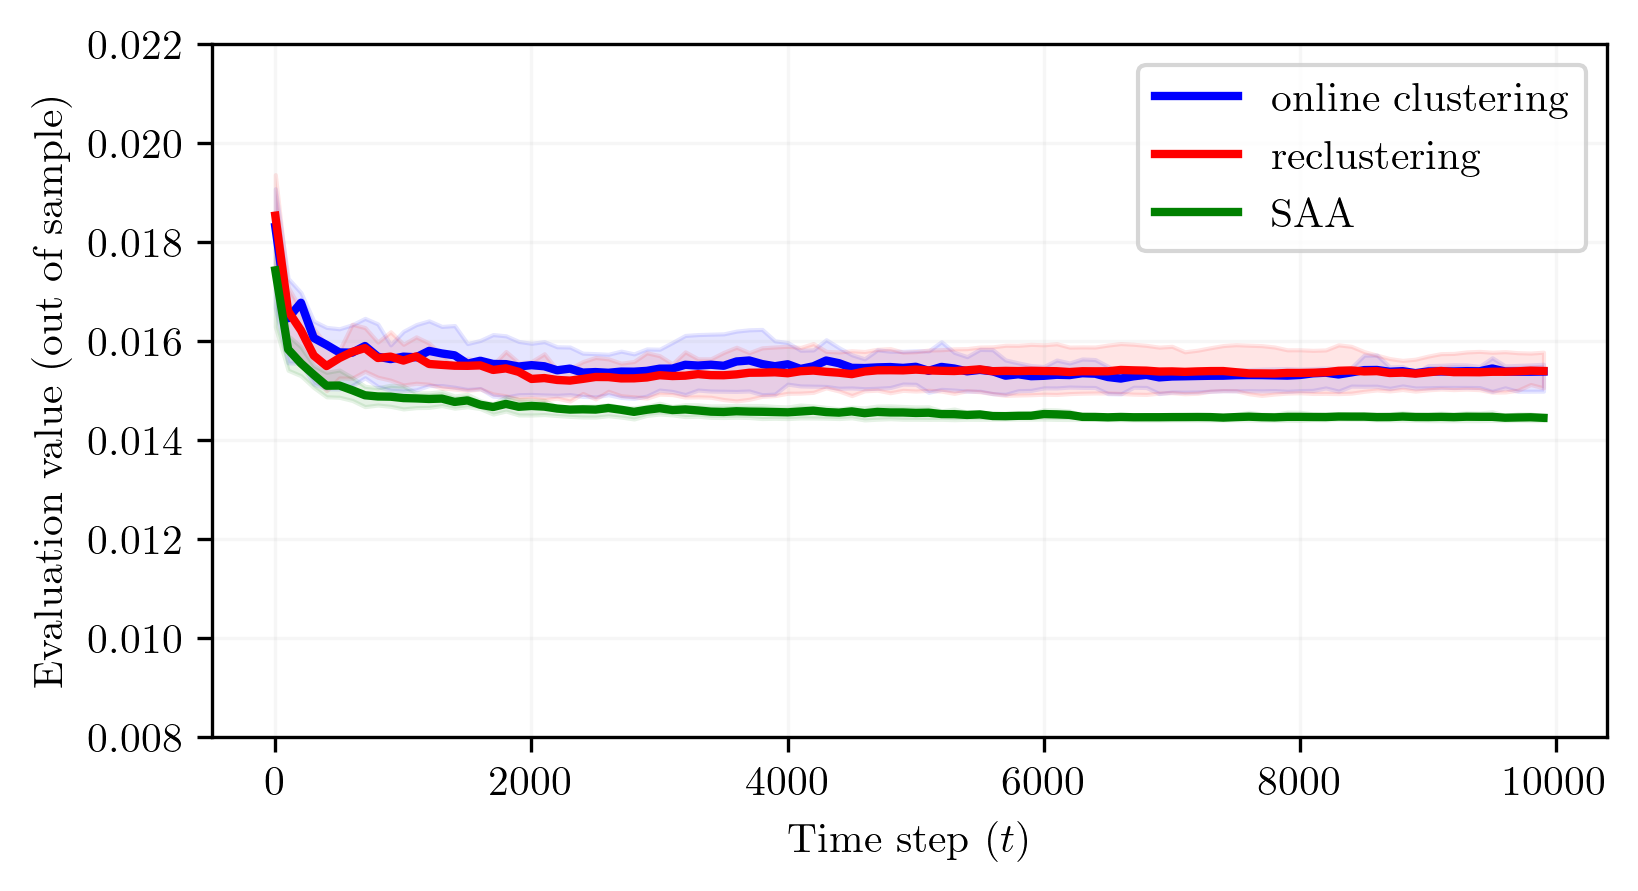

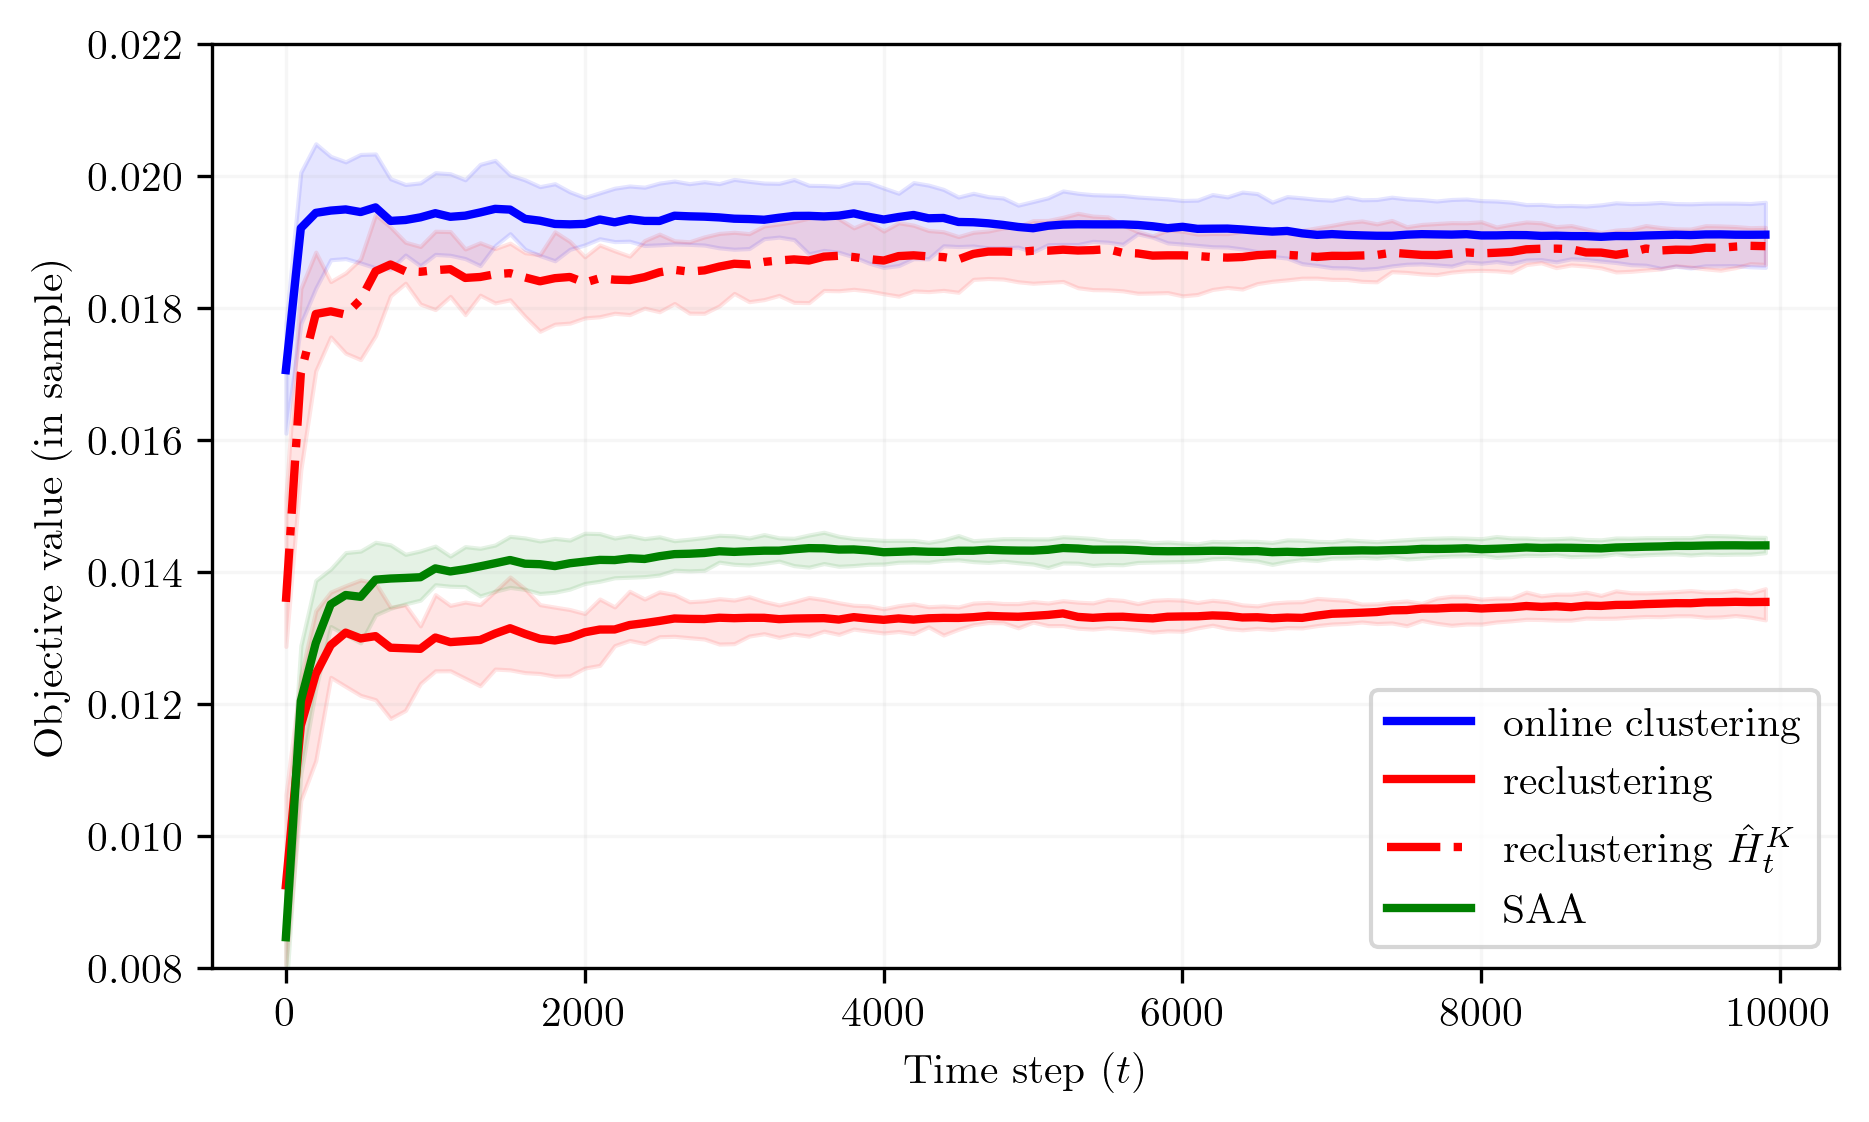

In [64]:
K = K_list[4]
plot_eval(df,quantiles,df[0],quantiles[0],j=(1,7,0),K=K,q=(25,75), dro=True,end_ind = 201)

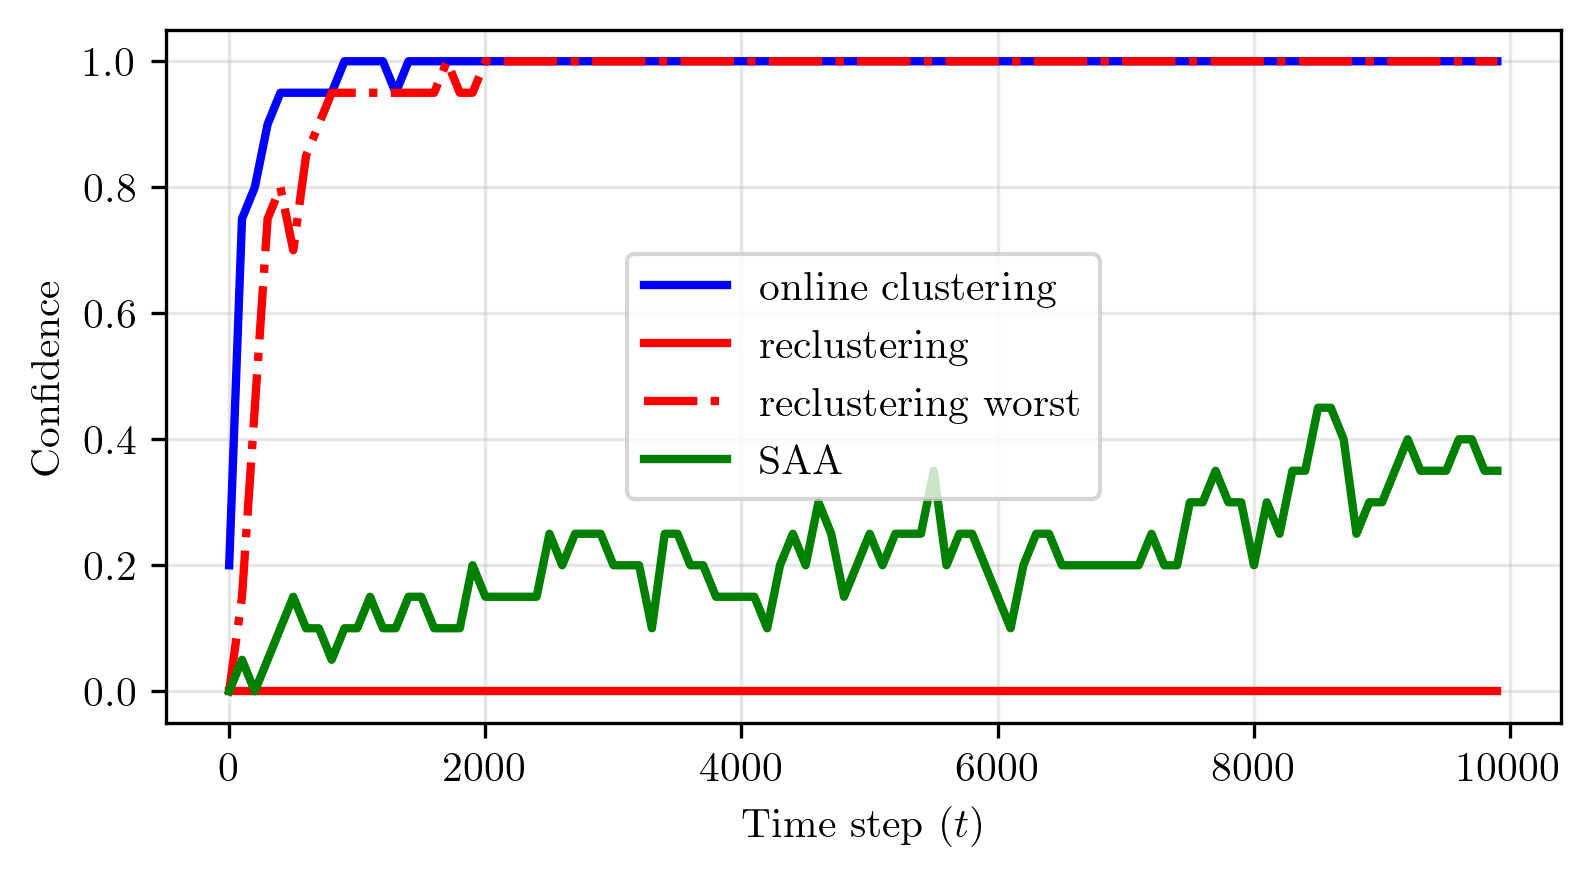

In [67]:
# dro 5/6 
# mro 6/7
# online 1
plot_satisfy(df,j=(1,8,0),K=15,df1=df[0],dro=True,end_ind = 201)

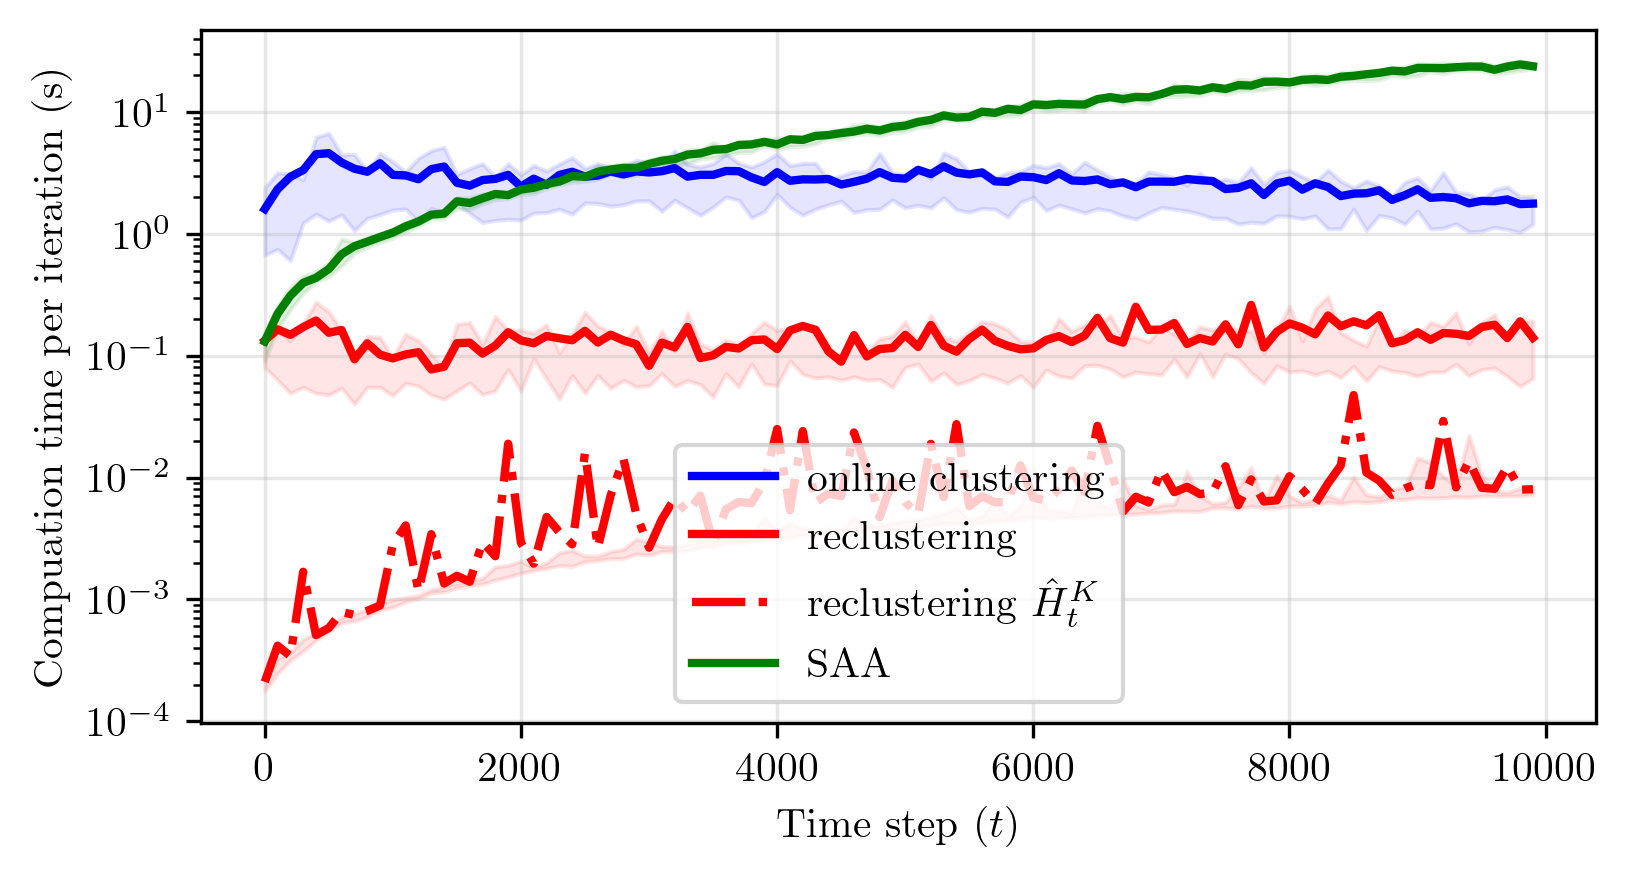

In [58]:
plot_computation_times_iter(df,quantiles,df[0],quantiles[0],j=(1,7,0),K=K,q=(25,75),dro=True, end_ind = 201)

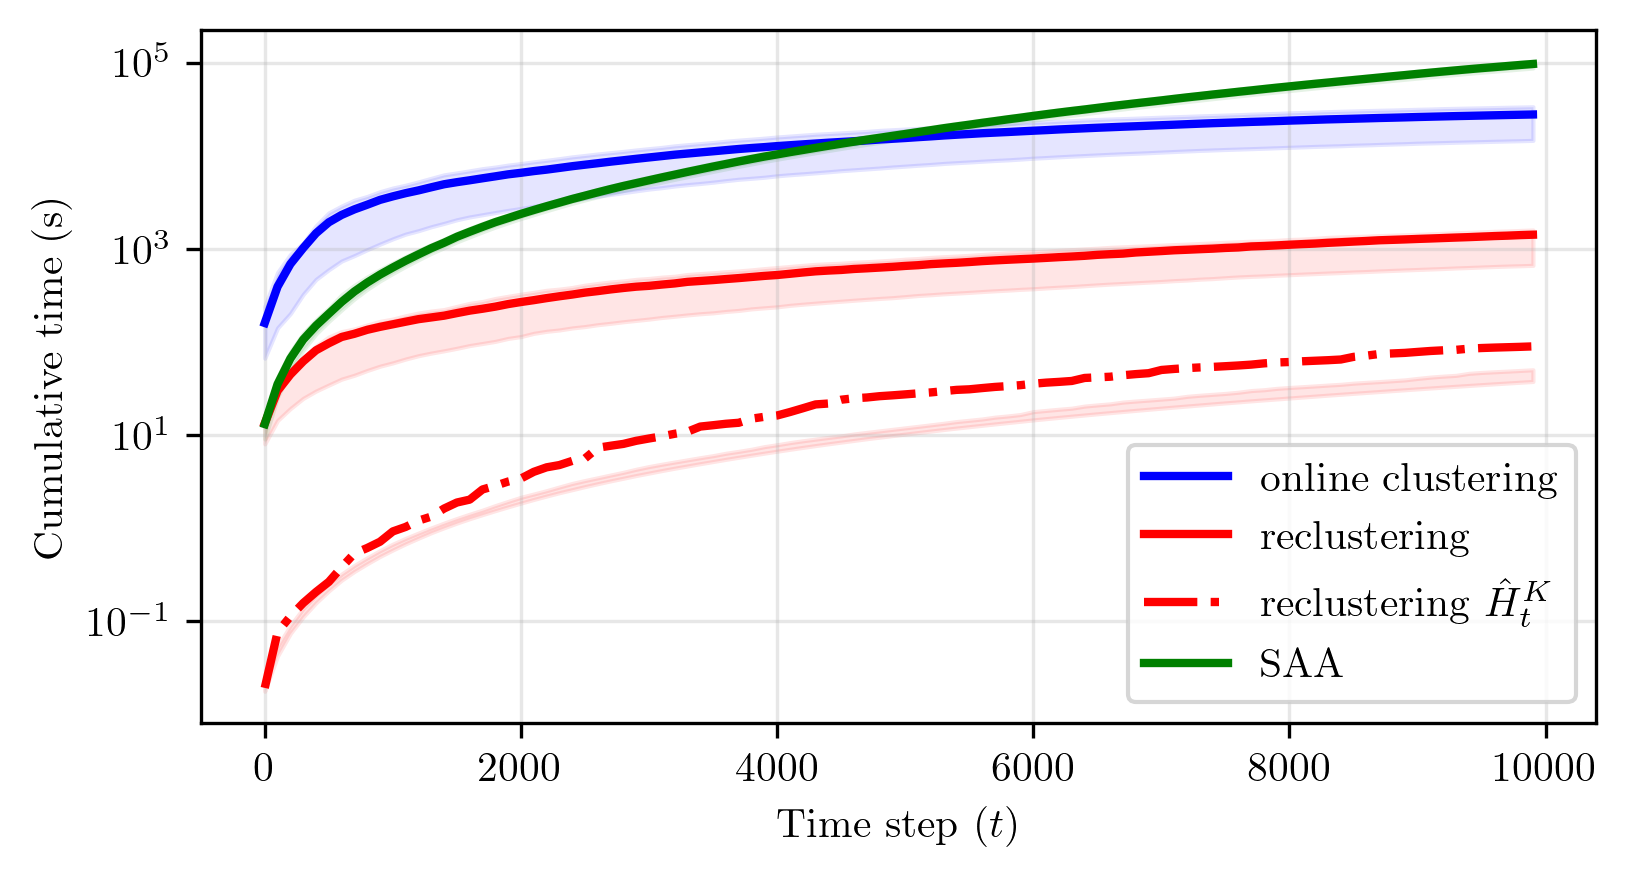

In [68]:
plot_computation_times_cum(df,quantiles,df[0],quantiles[0],j=(1,7,0),K=K,q=(25,75),dro=True,end_ind = 201)

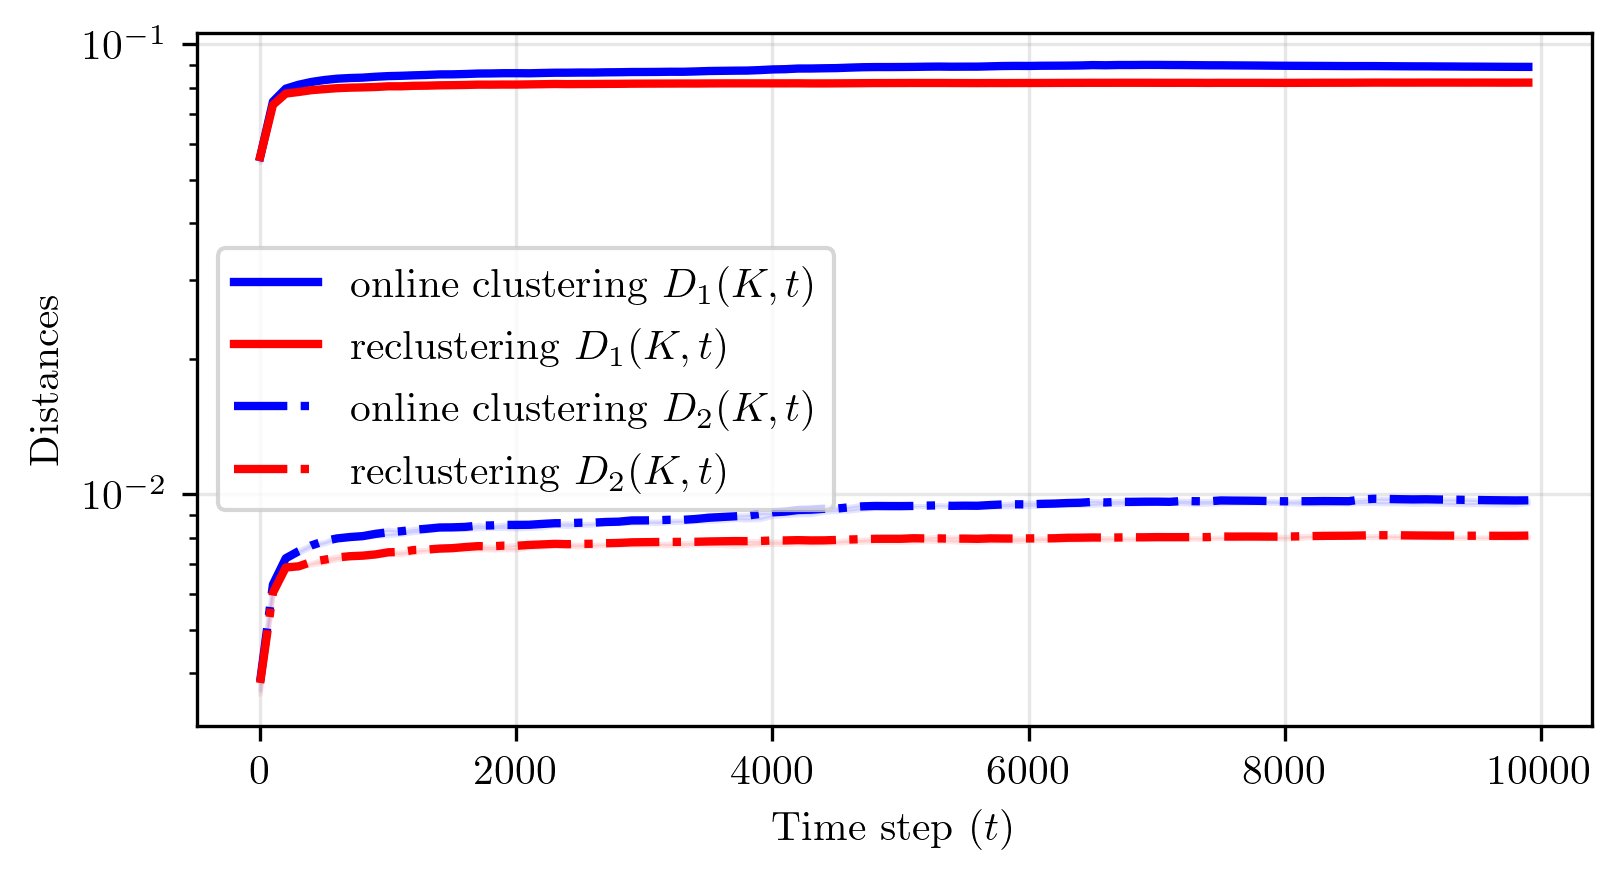

In [78]:
plot_dists(df,quantiles,end_ind=201,K=K)

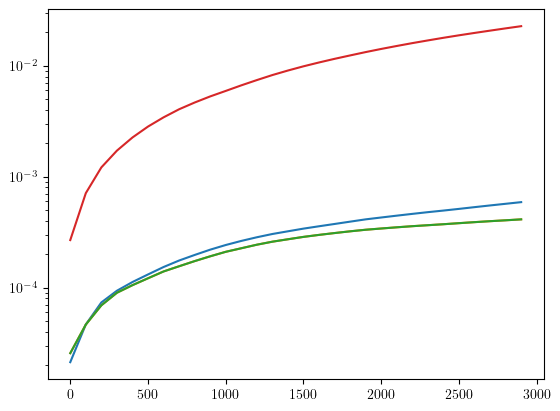

In [615]:
plt.plot(df[K]["t"][1:61:2],np.cumsum(df[K]["worst_values_regret"][1:61:2]-df[0]["DRO_obj_values"][1:61:2])/60)
plt.plot(df[K]["t"][1:61:2],np.cumsum(df[K]["MRO_worst_values_regret"][1:61:2]-df[0]["DRO_obj_values"][1:61:2])/60)
plt.plot(df[K]["t"][1:61:2],np.cumsum(df[K]["MRO_worst_values_regret"][1:61:2]-df[0]["DRO_obj_values"][1:61:2])/60)
plt.plot(df[K]["t"][1:61:2],np.cumsum(df[K]["MRO_sig_val"][1:61:2])/60)
plt.yscale("log")

In [ ]:
init_eps = 0.007
m = 30
plt.plot(df1['epsilon'])
plt.plot([init_eps*(1/(num_dat**(1/(2*m)))) for num_dat in range(50,3051) ])

In [ ]:
plt.plot(np.array(df1['sig_val']))
plt.plot(np.array(df1['MRO_sig_val']))
plt.show()
plt.plot(np.array(df1['mean_val']))
plt.plot(np.array(df1['MRO_mean_val']))
plt.show()
plt.plot(np.array(df1['square_val']))
plt.plot(np.array(df1['MRO_square_val']))
plt.show()

In [ ]:
df = df2
plt.plot(np.array(df['obj_values']), label = "online")
plt.plot(np.array(df['DRO_obj_values']), label = "DRO")
plt.plot(np.array(np.array(df['obj_values']) + df['sig_val']), label = "online + lb")
plt.plot(np.array(np.array(df['DRO_obj_values']) + df['sig_val']), label = "DRO + lb + ub")
plt.plot(np.array(df['eval']), linestyle = '-.', label = "online_eval")

plt.legend()
plt.show()

plt.plot(np.array(df['MRO_obj_values']), label = "MRO")
plt.plot(np.array(df['DRO_obj_values']), label = "DRO")
plt.plot(np.array(np.array(df['MRO_obj_values']) + df['MRO_sig_val']), label = "MRO + lb")
plt.plot(np.array(np.array(df['DRO_obj_values']) + df['MRO_sig_val']), label = "DRO + lb + ub")
plt.plot(np.array(df['MRO_eval']), linestyle = '-.', label = "MRO_eval")
plt.legend()
plt.show()